# Classification des images

Le projet consiste à développer un modèle de classification multi-classes d'images de champs de maïs, capturées à l'aide d'un smartphone, afin de simuler une vue depuis une machine de pulvérisation équipée d'une caméra. L'objectif est d'identifier les zones à arroser en distinguant quatre classes principales : sol sec sans végétation (ground), végétation de maïs (corn), plantes herbacées diverses (weeds), et une combinaison de maïs et de mauvaises herbes (corn/weeds).

## Import librairies

In [1]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=fd4f7e887e202fd434ad3824213422a020929466ca1ecf9d9de01192e0453528
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
import matplotlib.pyplot as plt
import cv2
import keras
import numpy as np
import os
import random
import seaborn as sns
from PIL import Image
from skimage.transform import resize
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.applications import VGG19, Xception
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

import lime
import lime.lime_image

## Load Dataset


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Data Exploration and Visualization


In [4]:
# Chemins vers les dossiers contenant les images de chaque classe
folder_Chaos_train = "/content/drive/MyDrive/Kaggle/ImagensTCCRotuladas/Treino/Chao"
folder_Ervas_train = "/content/drive/MyDrive/Kaggle/ImagensTCCRotuladas/Treino/Ervas"
folder_Milho_train = "/content/drive/MyDrive/Kaggle/ImagensTCCRotuladas/Treino/Milho"
folder_Milho_ervas_train = "/content/drive/MyDrive/Kaggle/ImagensTCCRotuladas/Treino/Milho_ervas"

folder_Chaos_test = "/content/drive/MyDrive/Kaggle/ImagensTCCRotuladas/Teste/Chao"
folder_Ervas_test = "/content/drive/MyDrive/Kaggle/ImagensTCCRotuladas/Teste/Ervas"
folder_Milho_test = "/content/drive/MyDrive/Kaggle/ImagensTCCRotuladas/Teste/Milho"

folder_Chaos_val = "/content/drive/MyDrive/Kaggle/ImagensTCCRotuladas/Valida+º+úo/Chao"
folder_Ervas_val = "/content/drive/MyDrive/Kaggle/ImagensTCCRotuladas/Valida+º+úo/Ervas"
folder_Milho_val = "/content/drive/MyDrive/Kaggle/ImagensTCCRotuladas/Valida+º+úo/Milho"

In [5]:
import os

def load_images_by_batches(folder_path, target_size=(224, 224)):
    ims = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)]
    random.shuffle(ims)  # Mélanger aléatoirement les images
    ims = ims[:int(len(ims) * 0.14)]  # Sélectionner 14% des images
    X_batches = []
    y_batches = []
    label = os.path.basename(folder_path)  # Obtenir le nom du dossier parent comme étiquette
    for image_path in ims:
        image = cv2.imread(image_path)
        image = cv2.resize(image, target_size)  # Redimensionner l'image
        X_batches.append(image)
        y_batches.append(label)  # Utiliser le nom du dossier comme étiquette
    return X_batches, y_batches

# Charger les images et créer les étiquettes pour chaque classe
X_Chaos_batches_train, y_Chaos_batches_train = load_images_by_batches(folder_Chaos_train)
X_Ervas_batches_train, y_Ervas_batches_train = load_images_by_batches(folder_Ervas_train)
X_Milho_batches_train, y_Milho_batches_train = load_images_by_batches(folder_Milho_train)


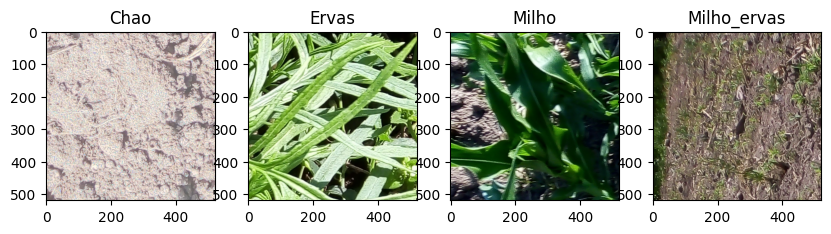

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

# Sélectionner une image aléatoire de chaque classe
Chao_img_name = random.choice(os.listdir(folder_Chaos_train))
Ervas_img_name = random.choice(os.listdir(folder_Ervas_train))
Milho_img_name = random.choice(os.listdir(folder_Milho_train))
Milho_ervas_img_name = random.choice(os.listdir(folder_Milho_ervas_train))

# Chemins complets des images
Chao_img_path = os.path.join(folder_Chaos_train, Chao_img_name)
Ervas_img_path = os.path.join(folder_Ervas_train, Ervas_img_name)
Milho_img_path = os.path.join(folder_Milho_train, Milho_img_name)
Milho_ervas_img_path = os.path.join(folder_Milho_ervas_train, Milho_ervas_img_name)

# Lire les images
Chao_img = mpimg.imread(Chao_img_path)
Ervas_img = mpimg.imread(Ervas_img_path)
Milho_img = mpimg.imread(Milho_img_path)
Milho_ervas_img = mpimg.imread(Milho_ervas_img_path)

# Afficher les images
plt.figure(figsize=(10, 10))

plt.subplot(1, 4, 1)
plt.imshow(Chao_img)
plt.title('Chao')

plt.subplot(1, 4, 2)
plt.imshow(Ervas_img)
plt.title('Ervas')

plt.subplot(1, 4, 3)
plt.imshow(Milho_img)
plt.title('Milho')

plt.subplot(1, 4, 4)
plt.imshow(Milho_ervas_img)
plt.title('Milho_ervas')

plt.show()


## Data processing

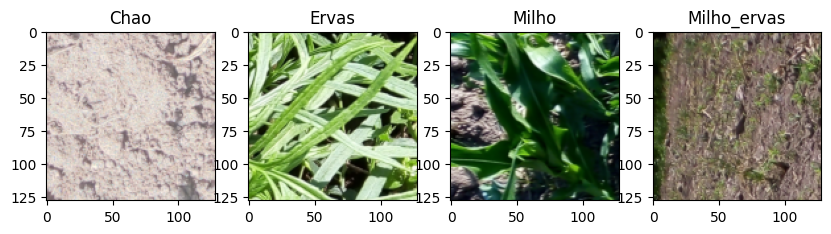

In [7]:
from skimage.transform import resize
# Fonction pour redimensionner une image
def resize_image(image_path, new_size=(128, 128)):
    image = mpimg.imread(image_path)
    resized_image = resize(image, new_size)
    return resized_image

# Redimensionner les images
new_size = (128, 128)
Chao_img = resize_image(Chao_img_path, new_size)
Ervas_img = resize_image(Ervas_img_path, new_size)
Milho_img = resize_image(Milho_img_path, new_size)
Milho_ervas_img = resize_image(Milho_ervas_img_path, new_size)

# Afficher les images
plt.figure(figsize=(10, 10))

plt.subplot(1, 4, 1)
plt.imshow(Chao_img)
plt.title('Chao')

plt.subplot(1, 4, 2)
plt.imshow(Ervas_img)
plt.title('Ervas')

plt.subplot(1, 4, 3)
plt.imshow(Milho_img)
plt.title('Milho')

plt.subplot(1, 4, 4)
plt.imshow(Milho_ervas_img)
plt.title('Milho_ervas')

plt.show()

In [8]:
# Charger les images pour l'entraînement, le test et la validation
X_Chaos_train, y_Chaos_train = load_images_by_batches(folder_Chaos_train)
X_Ervas_train, y_Ervas_train = load_images_by_batches(folder_Ervas_train)
X_Milho_train, y_Milho_train = load_images_by_batches(folder_Milho_train)

X_Chaos_test, y_Chaos_test = load_images_by_batches(folder_Chaos_test)
X_Ervas_test, y_Ervas_test = load_images_by_batches(folder_Ervas_test)
X_Milho_test, y_Milho_test = load_images_by_batches(folder_Milho_test)

X_Chaos_val, y_Chaos_val = load_images_by_batches(folder_Chaos_val)
X_Ervas_val, y_Ervas_val = load_images_by_batches(folder_Ervas_val)
X_Milho_val, y_Milho_val = load_images_by_batches(folder_Milho_val)

# Concaténer les ensembles de données en un seul tableau
X_train = np.concatenate((X_Chaos_train, X_Ervas_train, X_Milho_train), axis=0)
y_train = np.concatenate((y_Chaos_train, y_Ervas_train, y_Milho_train), axis=0)

X_test = np.concatenate((X_Chaos_test, X_Ervas_test, X_Milho_test), axis=0)
y_test = np.concatenate((y_Chaos_test, y_Ervas_test, y_Milho_test), axis=0)

X_val = np.concatenate((X_Chaos_val, X_Ervas_val, X_Milho_val), axis=0)
y_val = np.concatenate((y_Chaos_val, y_Ervas_val, y_Milho_val), axis=0)

# Normalisation des données
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0


In [9]:
print(X_val.shape)

(280, 224, 224, 3)


In [10]:

# Convertir les étiquettes en catégories (encodage one-hot)
num_classes = 3

In [11]:
from sklearn.preprocessing import LabelEncoder

# Convertir les noms de classe en nombres entiers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

# Convertir les nombres entiers en encodage one-hot
y_train = to_categorical(y_train_encoded, num_classes)
y_test = to_categorical(y_test_encoded, num_classes)
y_val = to_categorical(y_val_encoded, num_classes)

print(y_train.shape)


(2575, 3)


Prétraitement des données:


1.   Redimensionnement en 128 x128 et normalisation de l'image
  en niveaux de gris avec 255.0
2.   Séparation du jeu de données en 3 parties: entraînement, validation, test."




## CNN

### Build model

In [12]:
# Création du modèle CNN
model = Sequential()

# Ajout des couches
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Ajout de la couche de flattening
model.add(Flatten())

# Ajout des couches fully connected
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compilation du modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 64)      256       
 chNormalization)                                                
                                                        

### Fit with a validation set

In [14]:
# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Évaluation du modèle sur l'ensemble de test
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)


Epoch 1/10
81/81 [==============================] - 370s 5s/step - loss: 10.1492 - accuracy: 0.5755 - val_loss: 20.2203 - val_accuracy: 0.3464
Epoch 2/10
81/81 [==============================] - 360s 4s/step - loss: 0.9075 - accuracy: 0.5701 - val_loss: 7.9017 - val_accuracy: 0.2500
Epoch 3/10
81/81 [==============================] - 352s 4s/step - loss: 0.8113 - accuracy: 0.6229 - val_loss: 2.0314 - val_accuracy: 0.1464
Epoch 4/10
81/81 [==============================] - 352s 4s/step - loss: 0.9554 - accuracy: 0.6237 - val_loss: 0.9283 - val_accuracy: 0.5000
Epoch 5/10
81/81 [==============================] - 350s 4s/step - loss: 0.7584 - accuracy: 0.6575 - val_loss: 0.7910 - val_accuracy: 0.6250
Epoch 6/10
81/81 [==============================] - 345s 4s/step - loss: 0.7415 - accuracy: 0.6680 - val_loss: 0.7552 - val_accuracy: 0.6643
Epoch 7/10
81/81 [==============================] - 374s 5s/step - loss: 0.7083 - accuracy: 0.6784 - val_loss: 0.8075 - val_accuracy: 0.6929
Epoch 8/10


## Evaluation la performance des modèles

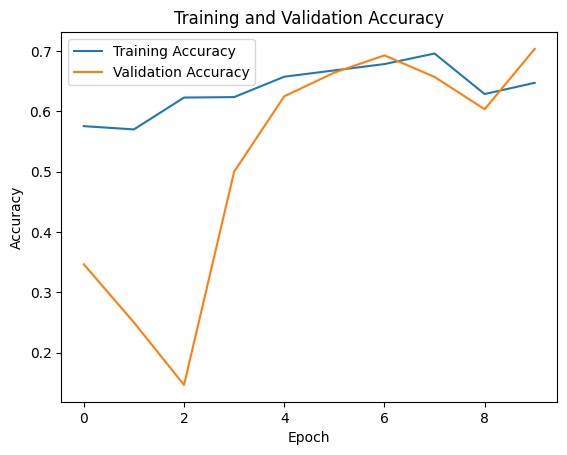

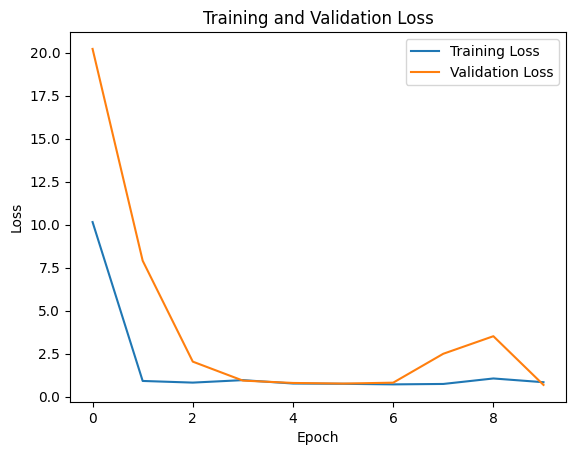

In [15]:
import matplotlib.pyplot as plt

# Tracer les courbes d'accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Tracer les courbes de loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Les courbes d'accuracy et de loss sur les ensembles d'entraînement et de validation pour observer la performance du modèle au fil des époques

la précision de l’entraînement est beaucoup plus élevée que la précision de la validation, cela peut indiquer un surapprentissage, c’est-à-dire que le modèle a trop appris les détails spécifiques des données d’entraînement et ne généralise pas bien à de nouvelles Images.

## Expérimentations  optimiseurs  Adam, RMSprop, Adagrad

Nous conservons les autres parametres dans les trois cas d'expérimentations

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


num_classes = 3
# Création du modèle CNN
model = Sequential()

# Ajout des couches
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

### Adam




In [ ]:
# Compilation du modèle avec l'optimiseur Adam
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Évaluation du modèle
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy with Adam optimizer: {}".format(test_acc))


In [ ]:
import matplotlib.pyplot as plt

# Tracer les courbes d'accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Tracer les courbes de loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### RMSprop

In [ ]:
# Compilation du modèle avec l'optimiseur Adam
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Évaluation du modèle
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy with Adam optimizer: {}".format(test_acc))

In [ ]:
import matplotlib.pyplot as plt

# Tracer les courbes d'accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Tracer les courbes de loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Adagrad

In [ ]:
# Compilation du modèle avec l'optimiseur Adam
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Évaluation du modèle
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy with Adam optimizer: {}".format(test_acc))

In [ ]:
import matplotlib.pyplot as plt

# Tracer les courbes d'accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Tracer les courbes de loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Expérimentations avec dropout en combinaison avec la normalisation

In [ ]:
from keras.layers import Dropout, BatchNormalization

# Liste des taux de dropout à expérimenter
dropout_rates = [0.2, 0.4, 0.6]

for rate in dropout_rates:
    # Ajout des couches
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Compilation du modèle
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Entraînement du modèle
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

    # Évaluation du modèle
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print("Test accuracy with dropout rate {}: {}".format(rate, test_acc))


La fonction Dropout est utilisée pour régulariser le modèle CNN .Lors de l’entraînement du
modèle, à chaque époque, la fonction Dropout désactive aléatoirement 20% ,40% ou 60% pourcentage de
neurones dans une couche donnée.

## Models préentrainés

### VGG16

GG16 est un modèle de réseau de neurones convolutifs. Il est composé de 16 couches de
convolution et de pooling, suivi de trois couches entièrement connectées. VGG16 est connu
pour sa simplicité et sa capacité à extraire des caractéristiques pertinentes à partir d’images

#### Build model

In [ ]:
# Charger le modèle VGG16 pré-entraîné
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler les couches du modèle VGG16 pour éviter de ré-entraîner les poids
for layer in vgg16_model.layers:
    layer.trainable = False

# Créer un nouveau modèle Sequential
model = Sequential()

# Ajouter les couches du modèle VGG16
model.add(vgg16_model)

# Ajouter des couches supplémentaires pour la classification
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compiler le modèle
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])




#### Fit with validation set

In [ ]:
# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

In [ ]:
import matplotlib.pyplot as plt

# Tracer les courbes d'accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Tracer les courbes de loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### VGG19

VGG19 est une variante de VGG16 avec 19 couches de convolution. Il partage la même
architecture de base, mais avec plus de paramètres

#### Build model

In [ ]:
# Charger le modèle VGG19 pré-entraîné
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


#### Fit with validation set

In [ ]:
# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

In [ ]:
import matplotlib.pyplot as plt

# Tracer les courbes d'accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Tracer les courbes de loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### xception_model

Xception est un modèle de réseau de neurones profond qui a été développé comme une
variante de l’architecture Inception. Il est basé sur des convolutions en profondeur et a étéconçu pour améliorer l’efficacité de calcul tout en maintenant de bonnes performances de
classification

####Build model

In [ ]:
# Charger le modèle Xception pré-entraîné
xception_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#### Fit model

In [ ]:
# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

In [ ]:
import matplotlib.pyplot as plt

# Tracer les courbes d'accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Tracer les courbes de loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Les images et la probabilité correspondant

In [ ]:
# Sélectionner quelques images de chaque classe pour les tests supplémentaires
# Assurez-vous de les prétraiter de la même manière que vos données d'entraînement

# Faire des prédictions sur ces images avec le modèle entraîné
y_pred = model.predict(X_selected_images)

# Afficher les images avec les prédictions et les probabilités correspondantes
for i in range(len(X_selected_images)):
    plt.imshow(X_selected_images[i])
    plt.title("Predicted class: {} (Probability: {:.2f})".format(np.argmax(y_pred[i]), np.max(y_pred[i])))
    plt.show()




## Lime

In [ ]:
# Utiliser LIME pour générer des superpixels explicatifs
explainer = lime.lime_image.LimeImageExplainer()
for i in range(len(X_selected_images)):
    explanation = explainer.explain_instance(X_selected_images[i].astype('double'), model.predict, top_labels=5)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title("Superpixels explicatifs pour la prédiction de classe: {}".format(np.argmax(y_pred[i])))
    plt.show()